<a href="https://colab.research.google.com/github/wyctorfogos/DarkNet---Classifier-PyTorch-/blob/main/Darknet_19_classifier_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.optim import Adam, SGD, RMSprop
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

torch.manual_seed(17)

In [2]:
transformations = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

In [33]:
from torchvision.datasets.fakedata import transforms

#train= datasets.CIFAR10(root='data', download=True, train=True, transform=transformations)
#test= datasets.CIFAR10(root='data',download=True, train=False, transform=transformations)

train = datasets.VOCDetection(root= './data', year = '2012', image_set = 'train', download = True, transform = transformations)
test = datasets.VOCDetection(root= './data', year = '2012', image_set = 'val', download = True, transform = transformations)

batch=1

dataset_train = DataLoader(train, batch_size=batch, shuffle=True)
dataset_test = DataLoader(test, batch_size=batch, shuffle=False)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


Test dataset

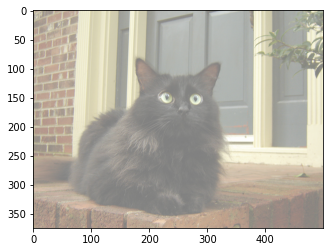

{'annotation': {'filename': ['2010_002573.jpg'], 'folder': ['VOC2012'], 'object': [{'name': ['cat'], 'bndbox': {'xmax': ['342'], 'xmin': ['63'], 'ymax': ['352'], 'ymin': ['79']}, 'difficult': ['0'], 'occluded': ['0'], 'pose': ['Frontal'], 'truncated': ['0']}], 'segmented': ['1'], 'size': {'depth': ['3'], 'height': ['375'], 'width': ['500']}, 'source': {'annotation': ['PASCAL VOC2010'], 'database': ['The VOC2010 Database'], 'image': ['flickr']}}}


In [34]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = iter(dataset_train)
images, labels = data_iter.next()

def plot_images(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
plot_images(torchvision.utils.make_grid(images))
print(labels)

del images
del labels

In [7]:
##Darknet-19 model

class BlockConv1(nn.Module):
  def __init__(self, input_channels, output_channels, num_kernel=1, size_stride=1, *kwgars):
    super().__init__()
    self.conv1 = nn.Conv2d(input_channels,output_channels, kernel_size=num_kernel*3, stride=size_stride, padding=1)
    self.batch1 = nn.BatchNorm2d(output_channels)
    self.conv2 = nn.Conv2d(output_channels,input_channels, kernel_size=num_kernel, stride=(size_stride), padding=0)
    self.batch2 = nn.BatchNorm2d(input_channels)
    self.conv3 = nn.Conv2d(input_channels,output_channels, kernel_size=num_kernel*3, stride=size_stride, padding=1)
    self.batch3 = nn.BatchNorm2d(output_channels)
    self.max_pool=nn.MaxPool2d(kernel_size=2, stride=2)
    self.relu= nn.ReLU()

  def forward(self,x):
    X = self.relu(self.batch1(self.conv1(x)))
    X= self.relu(self.batch2(self.conv2(X)))
    X = self.relu(self.conv3(X))
    X = self.conv3(X)
    X = self.relu(self.batch3(self.conv3(x)))
    X = self.max_pool(X)
    return X

class DarkNetClassifier(nn.Module):
  def __init__(self, Block1Conv1, input_channels=3, num__kernels=1,  num_stride=1, num_classes=20):
    self.num_classes=num_classes

    ##Darknet part
    super(DarkNetClassifier, self).__init__()
    self.conv1 = nn.Conv2d(input_channels,32, kernel_size = 3*num__kernels, stride = num_stride*3, padding=1, bias=False)
    self.batch1= nn.BatchNorm2d(32)
    self.max_pool1=nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv2 = nn.Conv2d(32,64, kernel_size = (3*num__kernels), stride = num_stride*3, padding=1, bias=False)
    self.batch2= nn.BatchNorm2d(64)
    self.max_pool2=nn.MaxPool2d(kernel_size = 2, stride = 2)

    ##self.block1 = BlockConv1(input_channels=64,output_channels=128,num_kernel=(num__kernels), size_stride=num_stride)
    ##self.block2 = BlockConv1(input_channels=128,output_channels=256,num_kernel=(num__kernels), size_stride=num_stride)
    self.conv1_block1 = nn.Conv2d(64, 128, kernel_size=num__kernels*3, stride=num_stride, padding=1)
    self.batch1_block1 = nn.BatchNorm2d(128)
    self.conv2_block1 = nn.Conv2d(128,64, kernel_size=num__kernels, stride=(num_stride), padding=0)
    self.batch2_block1 = nn.BatchNorm2d(64)
    self.conv3_block1 = nn.Conv2d(64,128, kernel_size=num__kernels*3, stride=num_stride, padding=1)
    self.batch3_block1 = nn.BatchNorm2d(128)
    self.max_pool1_block1=nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv1_block2 = nn.Conv2d(128, 256, kernel_size=num__kernels*3, stride=num_stride, padding=1)
    self.batch1_block2 = nn.BatchNorm2d(256)
    self.conv2_block2 = nn.Conv2d(256,128, kernel_size=num__kernels, stride=(num_stride), padding=0)
    self.batch2_block2 = nn.BatchNorm2d(128)
    self.conv3_block2 = nn.Conv2d(128,256, kernel_size=num__kernels*3, stride=num_stride, padding=1)
    self.batch3_block2 = nn.BatchNorm2d(256)
    self.max_pool1_block2=nn.MaxPool2d(kernel_size=2, stride=2)
  
    
    self.conv3 = nn.Conv2d(256,512, kernel_size = (3*num__kernels), stride = num_stride, padding=1, bias=False)
    self.batch3= nn.BatchNorm2d(512)
    self.conv4 = nn.Conv2d(512,256, kernel_size = (num__kernels), stride = (num_stride), padding=0, bias=False)
    self.batch4= nn.BatchNorm2d(256)
    self.conv5 = nn.Conv2d(256,512, kernel_size = (3*num__kernels), stride = num_stride, padding=1, bias=False)
    self.batch5= nn.BatchNorm2d(512)
    self.conv6 = nn.Conv2d(512,256, kernel_size = (num__kernels), stride = (num_stride), padding=1, bias=False)
    self.batch6= nn.BatchNorm2d(256)
    self.conv7 = nn.Conv2d(256,512, kernel_size = (3*num__kernels), stride = num_stride, padding=1, bias=False)
    self.batch7= nn.BatchNorm2d(512)
    self.max_pool3=nn.MaxPool2d(kernel_size = 2, stride = 2)

    self.conv8 = nn.Conv2d(512, 1024, kernel_size = (3*num__kernels), stride = num_stride, padding=1, bias=False)
    self.batch8= nn.BatchNorm2d(1024)
    self.conv9 = nn.Conv2d(1024, 512, kernel_size = (num__kernels), stride = num_stride, padding=0, bias=False)
    self.batch9= nn.BatchNorm2d(512)
    self.conv10 = nn.Conv2d(512, 1024, kernel_size = (3*num__kernels), stride = num_stride, padding=1, bias=False)
    self.batch10= nn.BatchNorm2d(1024)
    self.conv11 = nn.Conv2d(1024, 512, kernel_size = (num__kernels), stride = (num_stride), padding=1, bias=False)
    self.batch11= nn.BatchNorm2d(512)
    self.conv12 = nn.Conv2d(512, 1024, kernel_size = (3*num__kernels), stride = num_stride, padding=1, bias=False)
    self.batch12 = nn.BatchNorm2d(1024)

    self.conv_last_layer=nn.Conv2d(1024,num_classes,kernel_size=(1,1), stride = (1,1), padding=1, bias=False)

    self.flatten= nn.Flatten()
    self.soft=nn.Softmax(dim=1)

    self.relu= nn.ReLU(0.1)

    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)

  def forward(self,x):
    #model= self.soft(self.fc(self.avg(self.conv_last_layer(self.conv12(self.conv11(self.conv10(self.conv9(self.conv8(self.max_pool3(self.conv7(self.conv6(self.conv5(self.conv4(self.conv3(self.block2(self.block1(self.max_pool2(self.conv2(self.max_pool1(self.conv1(x)))))))))))))))))))))
    X = self.relu(self.batch1(self.conv1(x)))
    X = self.max_pool1(X)
    X = self.relu(self.batch2(self.conv2(X)))
    X = self.max_pool2(X)

    X = self.relu(self.batch1_block1(self.conv1_block1(X)))
    X = self.relu(self.batch2_block1(self.conv2_block1(X)))
    X = self.relu(self.batch3_block1(self.conv3_block1(X)))
    x = self.max_pool1_block1(X)
    
    X = self.relu(self.batch1_block2(self.conv1_block2(X)))
    X = self.relu(self.batch2_block2(self.conv2_block2(X)))
    X = self.relu(self.batch3_block2(self.conv3_block2(X)))
    X = self.max_pool1_block2(X)


    ##X = self.block1(X)
    ##X = self.block2(X)

    X = self.relu(self.batch7(self.conv7(self.relu(self.batch6(self.conv6(self.relu(self.batch5(self.conv5(self.relu(self.batch4(self.conv4(self.relu(self.batch3(self.conv3(X)))))))))))))))
    X = self.max_pool3(X)
    X = self.conv_last_layer(self.relu(self.batch12(self.conv12(self.relu(self.batch11(self.conv11(self.relu(self.batch10(self.conv10(self.relu(self.batch9(self.conv9(self.relu(self.batch8(self.conv8(X))))))))))))))))
    
    ##Classifier part
    N = X.data.size(0)
    C = X.data.size(1)
    H = X.data.size(2)
    W = X.data.size(3)

    #print(N,C,H,W)

    X = nn.AdaptiveAvgPool2d((H, W))(X)
    X = X.view(-1, (N*C*H*W))
 ##   X = self.soft(X)
    X = nn.Linear((N*C*H*W), self.num_classes)(X)
 #   x = X.view(X.size(0), -1)
 #   print(X.size(0))
 #   X = nn.Linear((N*C*H*W), self.num_classes)(X)
 #   X = self.fc2(X)
 #   model =self.fc3(X)
    #X = nn.Linear((N*C*H*W), self.num_classes)(X)

    
    return X



In [8]:

def test():
  model=DarkNetClassifier(BlockConv1, input_channels=3, num__kernels=1,  num_stride=1, num_classes=10)
  X=torch.rand(1, 3, 224, 224)
#  X.permute(0, 3, 1, 2)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
  Y = model(X).to(device)
#  Y = model.to(device)
  print(Y)
  #model.to(device)
  return model

In [9]:
model=test()
del model

tensor([[-0.1080, -0.1164,  0.0167, -0.0294, -0.0569, -0.0189,  0.1167, -0.1919,
          0.0037,  0.2086]], grad_fn=<AddmmBackward0>)


In [10]:
class ConvClassifier(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.max_pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)

    ##activation function
    self.relu= nn.ReLU()

  def forward(self,x):
    X = self.relu(self.conv1(x))
    X= self.max_pool(X)
    X = self.relu(self.conv2(X))
    X= self.max_pool(X)
    X = X.view(-1 ,16*5*5)
    X= self.fc1(X)
    X = self.fc2(X)
    model =self.fc3(X)
    
    return model

def test_ConvClassifier():
  model=ConvClassifier(num_classes=10)
  X=torch.rand(1,3,32,32)
  #X.permute(0, 3, 1, 2)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
  Y = model(X).to(device)
  print(torch.argmax(Y))
  #model.to(device)
  return model

In [11]:
model=test_ConvClassifier()

del model

tensor(8)


In [12]:
class_names={'person':0, 'bird': 1, 'cat':2, 'cow':3, 'dog':4, 'horse':5, 'sheep':6, 'aeroplane':7, 'bicycle':8, 'boat':9, 'bus':10, 'car':11, 'motorbike':12, 'train':13, 'bottle':14, 'chair':15, 'dining table':16, 'potted plant':17, 'sofa':18, 'tv/monitor':19}

In [13]:
number=class_names.get('bicycle')
print(number)

8


In [14]:
def crop_images(imgs, x_min, y_min, x_max, y_max):
  image=transforms.ToPILImage()(imgs)
  plt.subplot(2,2,1)
  plt.imshow(image, interpolation="bicubic")
  plt.subplot(2,2,2)
  
  cropped_image=transforms.ToPILImage()(imgs)
  width = abs(int(x_min)-int(x_max))
  height = abs(int(y_min)-int(y_max))

  # Select area to crop
  area = (int(x_min), int(y_min), int(x_max), int(y_max))
    
  cropped_image=cropped_image.crop(area)
  plt.imshow(cropped_image)
  plt.show()

In [15]:
def select_info(annotations):
  obj_name=annotations["annotation"]['object'][-1]['name']
  obj_coord=annotations["annotation"]['object'][-1]['bndbox']
  x_min, y_min, x_max, y_max = obj_coord['xmin'], obj_coord['ymin'], obj_coord['xmax'], obj_coord['ymax']
  return x_min, y_min, x_max, y_max, obj_name, obj_coord 

In [16]:
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

epochs=25

model= model=DarkNetClassifier(BlockConv1, input_channels=3, num__kernels=1,  num_stride=1, num_classes=10)
#test_ConvClassifier()
model.to(device)

loss_functionn= torch.nn.CrossEntropyLoss().to(device)
opt=Adam(model.parameters(), lr=1e-4)




In [17]:
def create_array(Y_pred):
  y_pred=[]
  max_item=int(torch.argmax(Y_pred))
  for id in range(Y_pred.shape[-1]):
    if id==max_item:
      y_pred.append(1)
    else:
      y_pred.append(0)
  return torch.tensor(y_pred)

In [18]:
aux=create_array(Y_pred)
print(aux)

NameError: ignored

Batch: 0
['dog']
{'xmin': ['252'], 'ymin': ['223'], 'xmax': ['301'], 'ymax': ['259']}
252 223 301 259


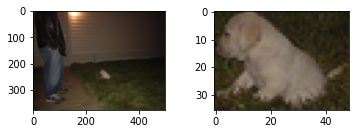

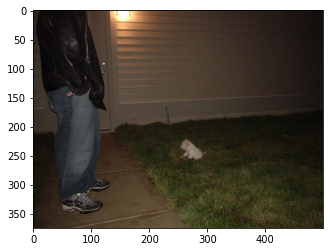

tensor([[-0.1771,  0.0204, -0.0441,  0.1159, -0.0209, -0.0532, -0.2523, -0.1209,
         -0.0158,  0.2376, -0.0952,  0.1636, -0.1505, -0.1031,  0.2875, -0.1918,
         -0.0752,  0.3066, -0.1583,  0.0607]], grad_fn=<AddmmBackward0>) tensor([4])
tensor(3.0162, grad_fn=<NllLossBackward0>)
Batch: 1
['person']
{'xmax': ['199'], 'xmin': ['160'], 'ymax': ['194'], 'ymin': ['141']}
160 141 199 194


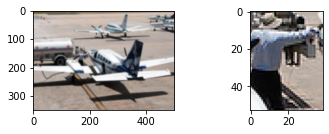

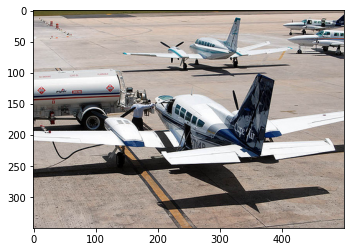

tensor([[-0.0900, -0.0667,  0.2058, -0.1991,  0.0179, -0.0851,  0.0216, -0.1803,
         -0.0795,  0.2688,  0.0974, -0.0145,  0.0480, -0.2163,  0.4254, -0.0905,
         -0.1472, -0.0515, -0.1278, -0.0838]], grad_fn=<AddmmBackward0>) tensor([0])
tensor(3.0818, grad_fn=<NllLossBackward0>)
Batch: 2
['cat']
{'xmax': ['306'], 'xmin': ['82'], 'ymax': ['294'], 'ymin': ['91']}
82 91 306 294


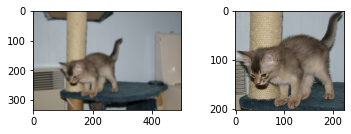

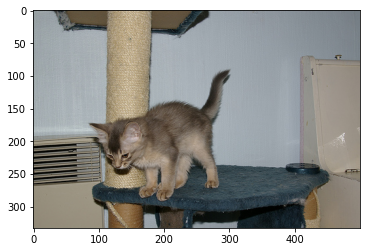

tensor([[ 1.3522e-02, -4.6046e-01, -2.6175e-01,  8.3222e-02,  2.6763e-01,
         -3.4879e-01, -1.3876e-01,  4.6013e-01, -4.1974e-04, -8.5204e-02,
         -2.0907e-01,  2.1223e-01, -4.0194e-03,  6.3879e-03, -3.2910e-01,
          3.9943e-02,  4.5581e-01, -1.0995e-01, -3.4894e-01,  6.6333e-02]],
       grad_fn=<AddmmBackward0>) tensor([2])
tensor(3.2547, grad_fn=<NllLossBackward0>)
Batch: 3
['car']
{'xmin': ['1'], 'ymin': ['175'], 'xmax': ['331'], 'ymax': ['491']}
1 175 331 491


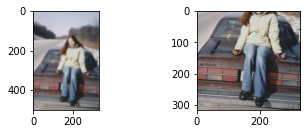

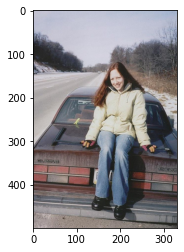

tensor([[-0.1579, -0.0947, -0.0207, -0.1730,  0.2107,  0.0331, -0.2257,  0.2271,
         -0.2710, -0.1904, -0.2645,  0.3259, -0.2247,  0.2442,  0.1597, -0.1158,
          0.0554,  0.1462, -0.1790,  0.1779]], grad_fn=<AddmmBackward0>) tensor([11])
tensor(2.6714, grad_fn=<NllLossBackward0>)
Batch: 4
['person']
{'xmin': ['38'], 'ymin': ['1'], 'xmax': ['352'], 'ymax': ['288']}
38 1 352 288


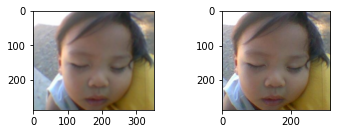

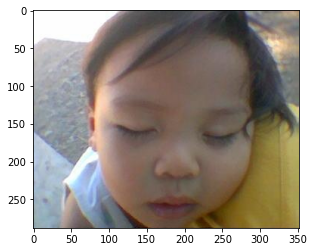

tensor([[ 0.2403, -0.1192, -0.0223,  0.0850, -0.1709, -0.2345,  0.0372, -0.0715,
         -0.3982, -0.3907, -0.2072, -0.0901,  0.1890, -0.1055, -0.3431, -0.0259,
          0.0432, -0.0851,  0.1232,  0.2011]], grad_fn=<AddmmBackward0>) tensor([0])
tensor(2.7048, grad_fn=<NllLossBackward0>)
Batch: 5
['bus']
{'xmax': ['246'], 'xmin': ['83'], 'ymax': ['226'], 'ymin': ['178']}
83 178 246 226


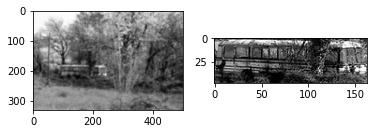

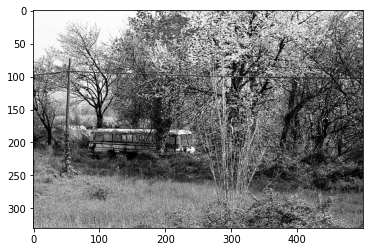

tensor([[ 0.0502,  0.0691,  0.0367,  0.1292, -0.3754,  0.1955, -0.0804,  0.1995,
          0.2084,  0.1740, -0.2399, -0.0429,  0.2018, -0.1774,  0.1635, -0.3215,
          0.3523,  0.0894, -0.1488,  0.0631]], grad_fn=<AddmmBackward0>) tensor([10])
tensor(3.2805, grad_fn=<NllLossBackward0>)
Batch: 6
['aeroplane']
{'xmax': ['183'], 'xmin': ['47'], 'ymax': ['201'], 'ymin': ['150']}
47 150 183 201


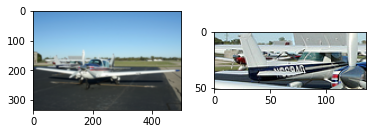

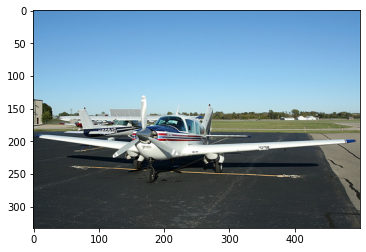

tensor([[-0.1132, -0.3686,  1.0448, -0.0578, -0.0326, -0.5737, -0.1071, -0.0288,
         -0.1386,  0.2135, -0.2331,  0.1284, -0.2893,  0.1457, -0.5268,  0.0553,
         -0.3911,  0.0314, -0.3864,  0.3685]], grad_fn=<AddmmBackward0>) tensor([7])
tensor(3.0343, grad_fn=<NllLossBackward0>)
Batch: 7
['person']
{'xmax': ['500'], 'xmin': ['11'], 'ymax': ['371'], 'ymin': ['1']}
11 1 500 371


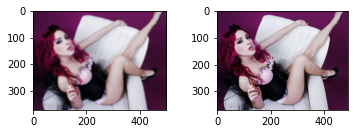

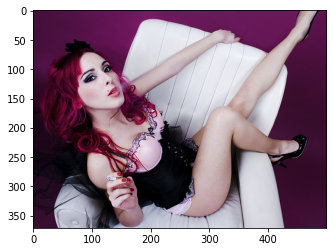

tensor([[-0.5699, -0.1299,  0.6462,  0.2208, -0.4601, -0.1875,  0.2981,  0.0809,
         -0.1628,  0.0156,  0.4004,  0.2649, -0.0265,  0.7734,  0.4325, -0.1472,
          0.1495,  0.3844, -0.1772, -0.4816]], grad_fn=<AddmmBackward0>) tensor([0])
tensor(3.6959, grad_fn=<NllLossBackward0>)
Batch: 8
['person']
{'xmin': ['9'], 'ymin': ['2'], 'xmax': ['500'], 'ymax': ['375']}
9 2 500 375


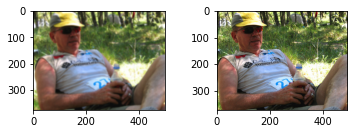

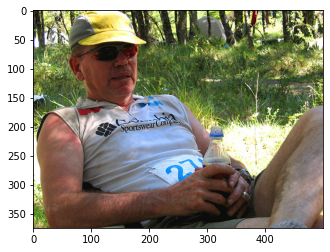

tensor([[-0.0921,  0.6883,  0.1983,  0.4231,  0.1245, -0.0545, -0.0160, -0.0486,
         -0.2408, -0.2183,  0.3247,  0.6039, -0.2262, -0.2583,  0.1276,  0.6800,
          0.5665, -0.0019,  0.2632, -0.4128]], grad_fn=<AddmmBackward0>) tensor([0])
tensor(3.2648, grad_fn=<NllLossBackward0>)
Batch: 9
['pottedplant']
{'xmin': ['35'], 'ymin': ['27'], 'xmax': ['362'], 'ymax': ['456']}
35 27 362 456


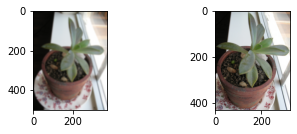

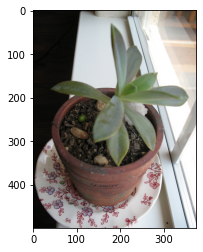

tensor([[-0.1613,  0.5661,  0.5394,  0.5934,  0.3407,  0.5349,  0.2043,  0.4822,
         -0.0762, -0.5644, -0.2733, -0.1999, -0.5915, -0.6086, -0.1246,  0.0165,
         -0.0206,  0.3138, -0.2398,  0.0418]], grad_fn=<AddmmBackward0>) tensor([0])
tensor(3.2679, grad_fn=<NllLossBackward0>)
Batch: 10
['dog']
{'xmax': ['463'], 'xmin': ['236'], 'ymax': ['354'], 'ymin': ['201']}
236 201 463 354


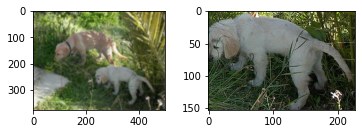

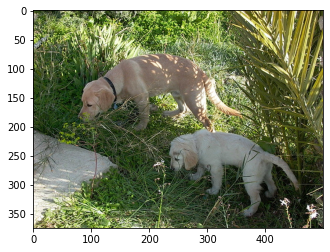

tensor([[ 0.2625,  0.1371, -0.4618,  0.4788, -0.3855, -0.5565,  0.1002, -0.3371,
          0.0386, -0.3341, -0.3731, -0.6593,  0.2948,  0.1738, -0.2821,  0.3509,
          0.5446,  0.0161, -0.0260,  0.0612]], grad_fn=<AddmmBackward0>) tensor([4])
tensor(3.3917, grad_fn=<NllLossBackward0>)
Batch: 11
['chair']
{'xmin': ['237'], 'ymin': ['310'], 'xmax': ['291'], 'ymax': ['404']}
237 310 291 404


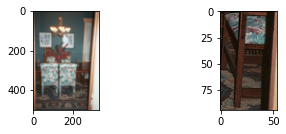

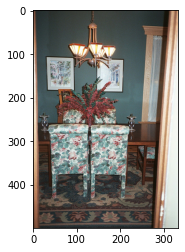

tensor([[ 0.5244,  0.0883,  0.0671, -0.2091, -0.2192, -0.0279,  0.1002,  0.1628,
         -0.2113, -0.2461,  0.3962, -0.4302,  0.1808, -0.0643, -0.3666, -0.7555,
         -0.0116, -0.1234, -0.2487,  0.0349]], grad_fn=<AddmmBackward0>) tensor([15])
tensor(3.7225, grad_fn=<NllLossBackward0>)
Batch: 12
['car']
{'xmin': ['252'], 'ymin': ['227'], 'xmax': ['311'], 'ymax': ['271']}
252 227 311 271


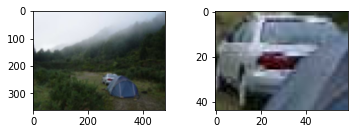

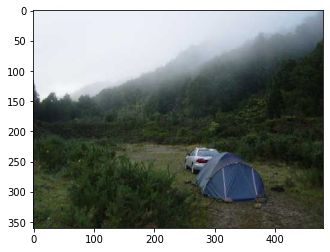

tensor([[-0.9296, -0.3183,  0.7740,  0.4374,  0.4345, -0.6823,  0.3165, -0.3138,
         -0.5854,  0.0349, -0.1289, -0.3372, -0.2448, -0.1532, -0.6434,  0.0806,
          0.6644, -0.7645,  0.3945, -0.2032]], grad_fn=<AddmmBackward0>) tensor([11])
tensor(3.3397, grad_fn=<NllLossBackward0>)
Batch: 13
['person']
{'xmax': ['333'], 'xmin': ['197'], 'ymax': ['500'], 'ymin': ['110']}
197 110 333 500


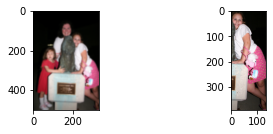

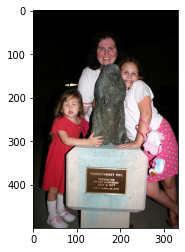

tensor([[-0.5728, -0.2975,  0.5342, -0.3163,  0.2965,  0.6915, -0.5717, -0.2845,
         -0.3506, -0.3808, -0.0431, -0.3947, -0.1844,  0.0044,  0.3745,  0.3292,
         -0.0329, -0.6324,  0.1304, -0.0714]], grad_fn=<AddmmBackward0>) tensor([0])
tensor(3.5519, grad_fn=<NllLossBackward0>)
Batch: 14
['tvmonitor']
{'xmax': ['150'], 'xmin': ['1'], 'ymax': ['203'], 'ymin': ['47']}
1 47 150 203


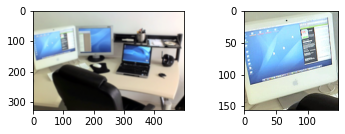

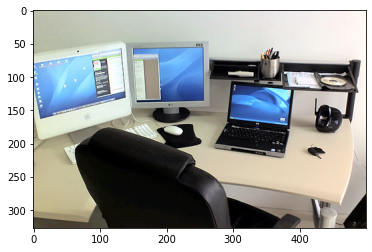

tensor([[-0.7282,  0.2899, -0.4921,  0.3013,  0.2179,  0.3090, -0.0981,  0.0929,
          0.5590, -0.1295, -0.2761, -0.1785,  0.3878,  0.0548, -0.1524, -0.1239,
         -0.4382,  0.1728, -0.3025, -0.6155]], grad_fn=<AddmmBackward0>) tensor([0])
tensor(3.7239, grad_fn=<NllLossBackward0>)
Batch: 15
['person']
{'xmin': ['70'], 'ymin': ['71'], 'xmax': ['185'], 'ymax': ['212']}
70 71 185 212


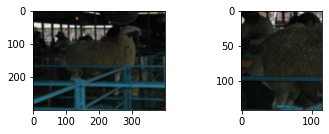

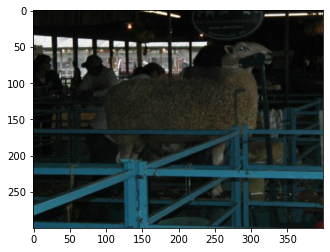

tensor([[-0.8273, -1.0069, -0.1356,  0.0489,  0.2265, -0.1054, -0.3711, -0.3425,
         -0.4863, -0.1927,  0.0132,  0.0718,  0.0646,  0.3411, -0.1699,  0.5399,
          0.2703, -0.2064, -0.2321, -0.1432]], grad_fn=<AddmmBackward0>) tensor([0])
tensor(3.7517, grad_fn=<NllLossBackward0>)
Batch: 16
['sofa']
{'xmax': ['500'], 'xmin': ['34'], 'ymax': ['297'], 'ymin': ['1']}
34 1 500 297


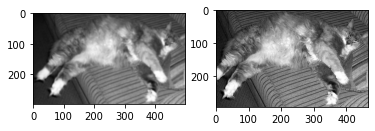

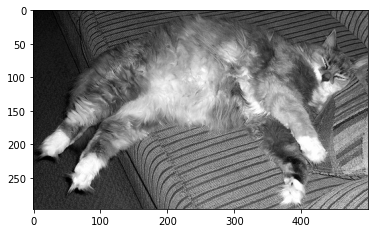

tensor([[ 0.6824,  0.2943, -0.4805, -0.7308, -0.4018, -0.2762, -0.1358,  0.3971,
         -0.3463,  0.0915,  0.1221,  0.1726,  0.5327, -0.5544, -0.2264,  0.2041,
         -0.2954,  0.2296,  0.1723, -0.3582]], grad_fn=<AddmmBackward0>) tensor([18])
tensor(2.8492, grad_fn=<NllLossBackward0>)
Batch: 17
['cow']
{'xmax': ['369'], 'xmin': ['180'], 'ymax': ['341'], 'ymin': ['106']}
180 106 369 341


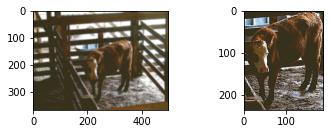

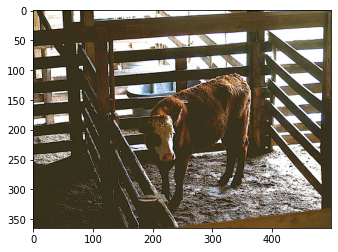

tensor([[ 0.1036, -0.5784, -0.1789, -0.0715, -0.0555,  0.3249,  0.2012, -0.1209,
         -0.0517,  0.0959, -0.1039, -0.3946,  0.0381,  0.2099,  0.8172, -0.1984,
          0.6196,  0.7613, -0.0220,  0.5963]], grad_fn=<AddmmBackward0>) tensor([3])
tensor(3.2349, grad_fn=<NllLossBackward0>)
Batch: 18
['bird']
{'xmax': ['190'], 'xmin': ['181'], 'ymax': ['283'], 'ymin': ['273']}
181 273 190 283


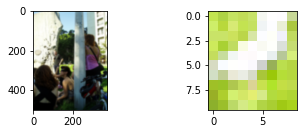

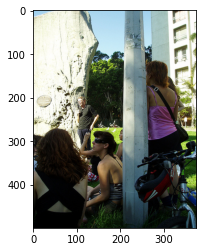

tensor([[-0.2643,  0.4178,  0.0877,  0.3598, -0.4687,  0.1940,  0.1739, -0.1647,
          0.2668, -0.0853, -0.6095, -0.2809,  0.3607,  0.3942, -0.1172, -0.1912,
          0.3740,  0.6200,  0.3504, -0.0238]], grad_fn=<AddmmBackward0>) tensor([1])
tensor(2.6981, grad_fn=<NllLossBackward0>)
Batch: 19
['dog']
{'xmax': ['365'], 'xmin': ['1'], 'ymax': ['500'], 'ymin': ['1']}
1 1 365 500


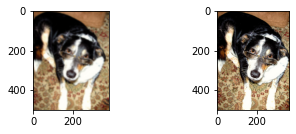

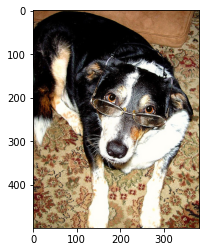

tensor([[ 0.1397,  0.4083, -0.3882,  0.0727, -0.0499, -0.2719, -0.6012, -0.4303,
         -0.4302,  0.1816, -0.4894,  0.5810,  0.0752, -0.3699, -0.0042,  0.3619,
          0.1226, -0.3151,  0.0856, -0.2475]], grad_fn=<AddmmBackward0>) tensor([4])
tensor(3.0203, grad_fn=<NllLossBackward0>)
Batch: 20
['bird']
{'xmax': ['367'], 'xmin': ['211'], 'ymax': ['208'], 'ymin': ['81']}
211 81 367 208


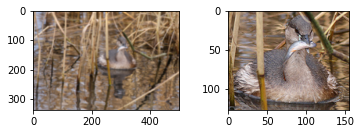

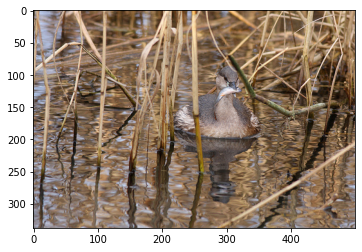

tensor([[-0.0222,  0.5301, -0.2045,  0.1638,  0.4742, -0.2430, -0.4322, -0.3093,
         -0.3194,  0.2570, -0.3450,  0.1219,  0.1001, -0.0676,  0.1968,  0.4033,
          0.1048,  0.3308,  0.4063, -0.4813]], grad_fn=<AddmmBackward0>) tensor([1])
tensor(2.5462, grad_fn=<NllLossBackward0>)
Batch: 21
['sheep']
{'xmax': ['415'], 'xmin': ['30'], 'ymax': ['375'], 'ymin': ['59']}
30 59 415 375


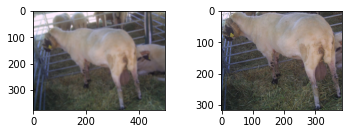

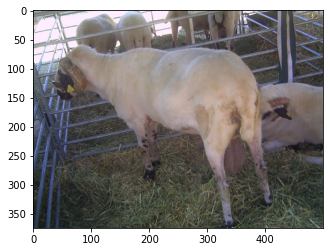

tensor([[-0.4448,  0.6787, -0.1171,  0.7724, -0.0324, -0.0795, -0.4380, -0.3498,
          0.2045,  0.1669, -1.0490, -0.3624,  0.3124, -0.1762, -0.7725, -0.1110,
         -0.3681,  0.1270,  0.2074,  0.0621]], grad_fn=<AddmmBackward0>) tensor([6])
tensor(3.4361, grad_fn=<NllLossBackward0>)


KeyboardInterrupt: ignored

In [38]:
import matplotlib.pyplot as plt
from PIL import Image

k=0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

epochs=25

model= model=DarkNetClassifier(BlockConv1, input_channels=3, num__kernels=1,  num_stride=1, num_classes=20)
#test_ConvClassifier()
model.to(device)

loss_functionn= torch.nn.CrossEntropyLoss().to(device)
opt=Adam(model.parameters(), lr=1e-4)


for epoch in range(epochs):
  ##for imgs, annotations in dataset_train.dataset:
  ##for i, (imgs, annotations) in enumerate(dataset_train):
  for batch in dataset_train:
    imgs, annotations = batch
    print("Batch: {}".format(k))
    #imgs = list(img.to(device) for img in imgs)
    #annotations = dict(annotations.items())

    image_copied=imgs
    image_copied = image_copied.squeeze(axis=0) #.to(device)

    imgs=transforms.Resize((224,224))(imgs)

        #X=X.squeeze(axis=0)
    x_min, y_min, x_max, y_max, obj_name, obj_coord = select_info(annotations)
    x_min, y_min, x_max, y_max=x_min[0], y_min[0], x_max[0], y_max[0]
    print(obj_name)
    print(obj_coord)
    print(x_min, y_min, x_max, y_max)
    
    Y=class_names.get(obj_name[0])
    if Y is None:
      Y = 0
    Y=torch.tensor(Y, dtype=torch.long).reshape(-1,1)
    Y=Y.squeeze(0)

    ##Y=F.one_hot(Y, num_classes=20)
    #Y=annotations

    ##Crop images
    crop_images(image_copied, x_min, y_min, x_max, y_max)

    image_copied_=transforms.ToPILImage()(image_copied)
    plt.imshow(image_copied_)
    plt.show()
    
    Y_pred= model(imgs)
    ##aux=create_array(Y_pred)
    ##print("Label: {}".format(torch.argmax(aux)))
    ##print("Prediction: {}".format(torch.argmax(Y)))

    ##print(aux)
    ##print(Y.squeeze(0).squeeze(0))
    #Y_pred=torch.argmax(Y_pred)
    #loss= loss_functionn(aux,Y.squeeze(0).squeeze(0))

    print(Y_pred,Y)

    loss= loss_functionn(Y_pred,Y)
    print(loss)
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    k+=1
    
    del annotations
    del Y_pred
    del imgs
  print("Epoch:{}, loss:{}".format(epoch, loss.item()))

In [ ]:
no_of_layers=0
conv_layers=[]
 
model_children=list(model.children())
 
for child in model_children:
  if type(child)==nn.Conv2d:
    no_of_layers+=1
    conv_layers.append(child)
  elif type(child)==nn.Sequential:
    for layer in child.children():
      if type(layer)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(layer)
print(no_of_layers)

In [ ]:
results = [conv_layers[0](imgs)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

In [ ]:
import cv2

for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print("Layer ",num_layer+1)
    for i, filter in enumerate(layer_viz):
        if i == 16: 
            break
        plt.subplot(2, 8, i + 1)
        image = cv2.cvtColor(abs(filter.cpu().numpy()), cv2.COLOR_BGR2RGB)
        plt.imshow(image, cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()

In [ ]:
for i in range(10):
  image_copied=transforms.ToPILImage()(layer_viz[i])
  plt.imshow(image_copied)
  plt.show()
